In [1]:
%matplotlib notebook
import copy
import numpy as np
import pandas as pd 
import geopandas as gpd
import rasterio as rio
from rasterio import warp
from rasterio.plot import show
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
from rasterio.transform import TransformMethodsMixin
import pickle as pkl
from os import listdir, makedirs
from os.path import isfile, join, exists
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

In [2]:
with open('data/allCompiledData.pkl', 'rb') as handle:
    is2data = pkl.load(handle)
ponds = list(is2data)[:-1]
dfdepth = is2data['depth_all_df']

# refractive index
ri = 1.34
dfdepth.moussavi_pope *= ri
dfdepth.spergel_kingslake *= ri

<IPython.core.display.Javascript object>


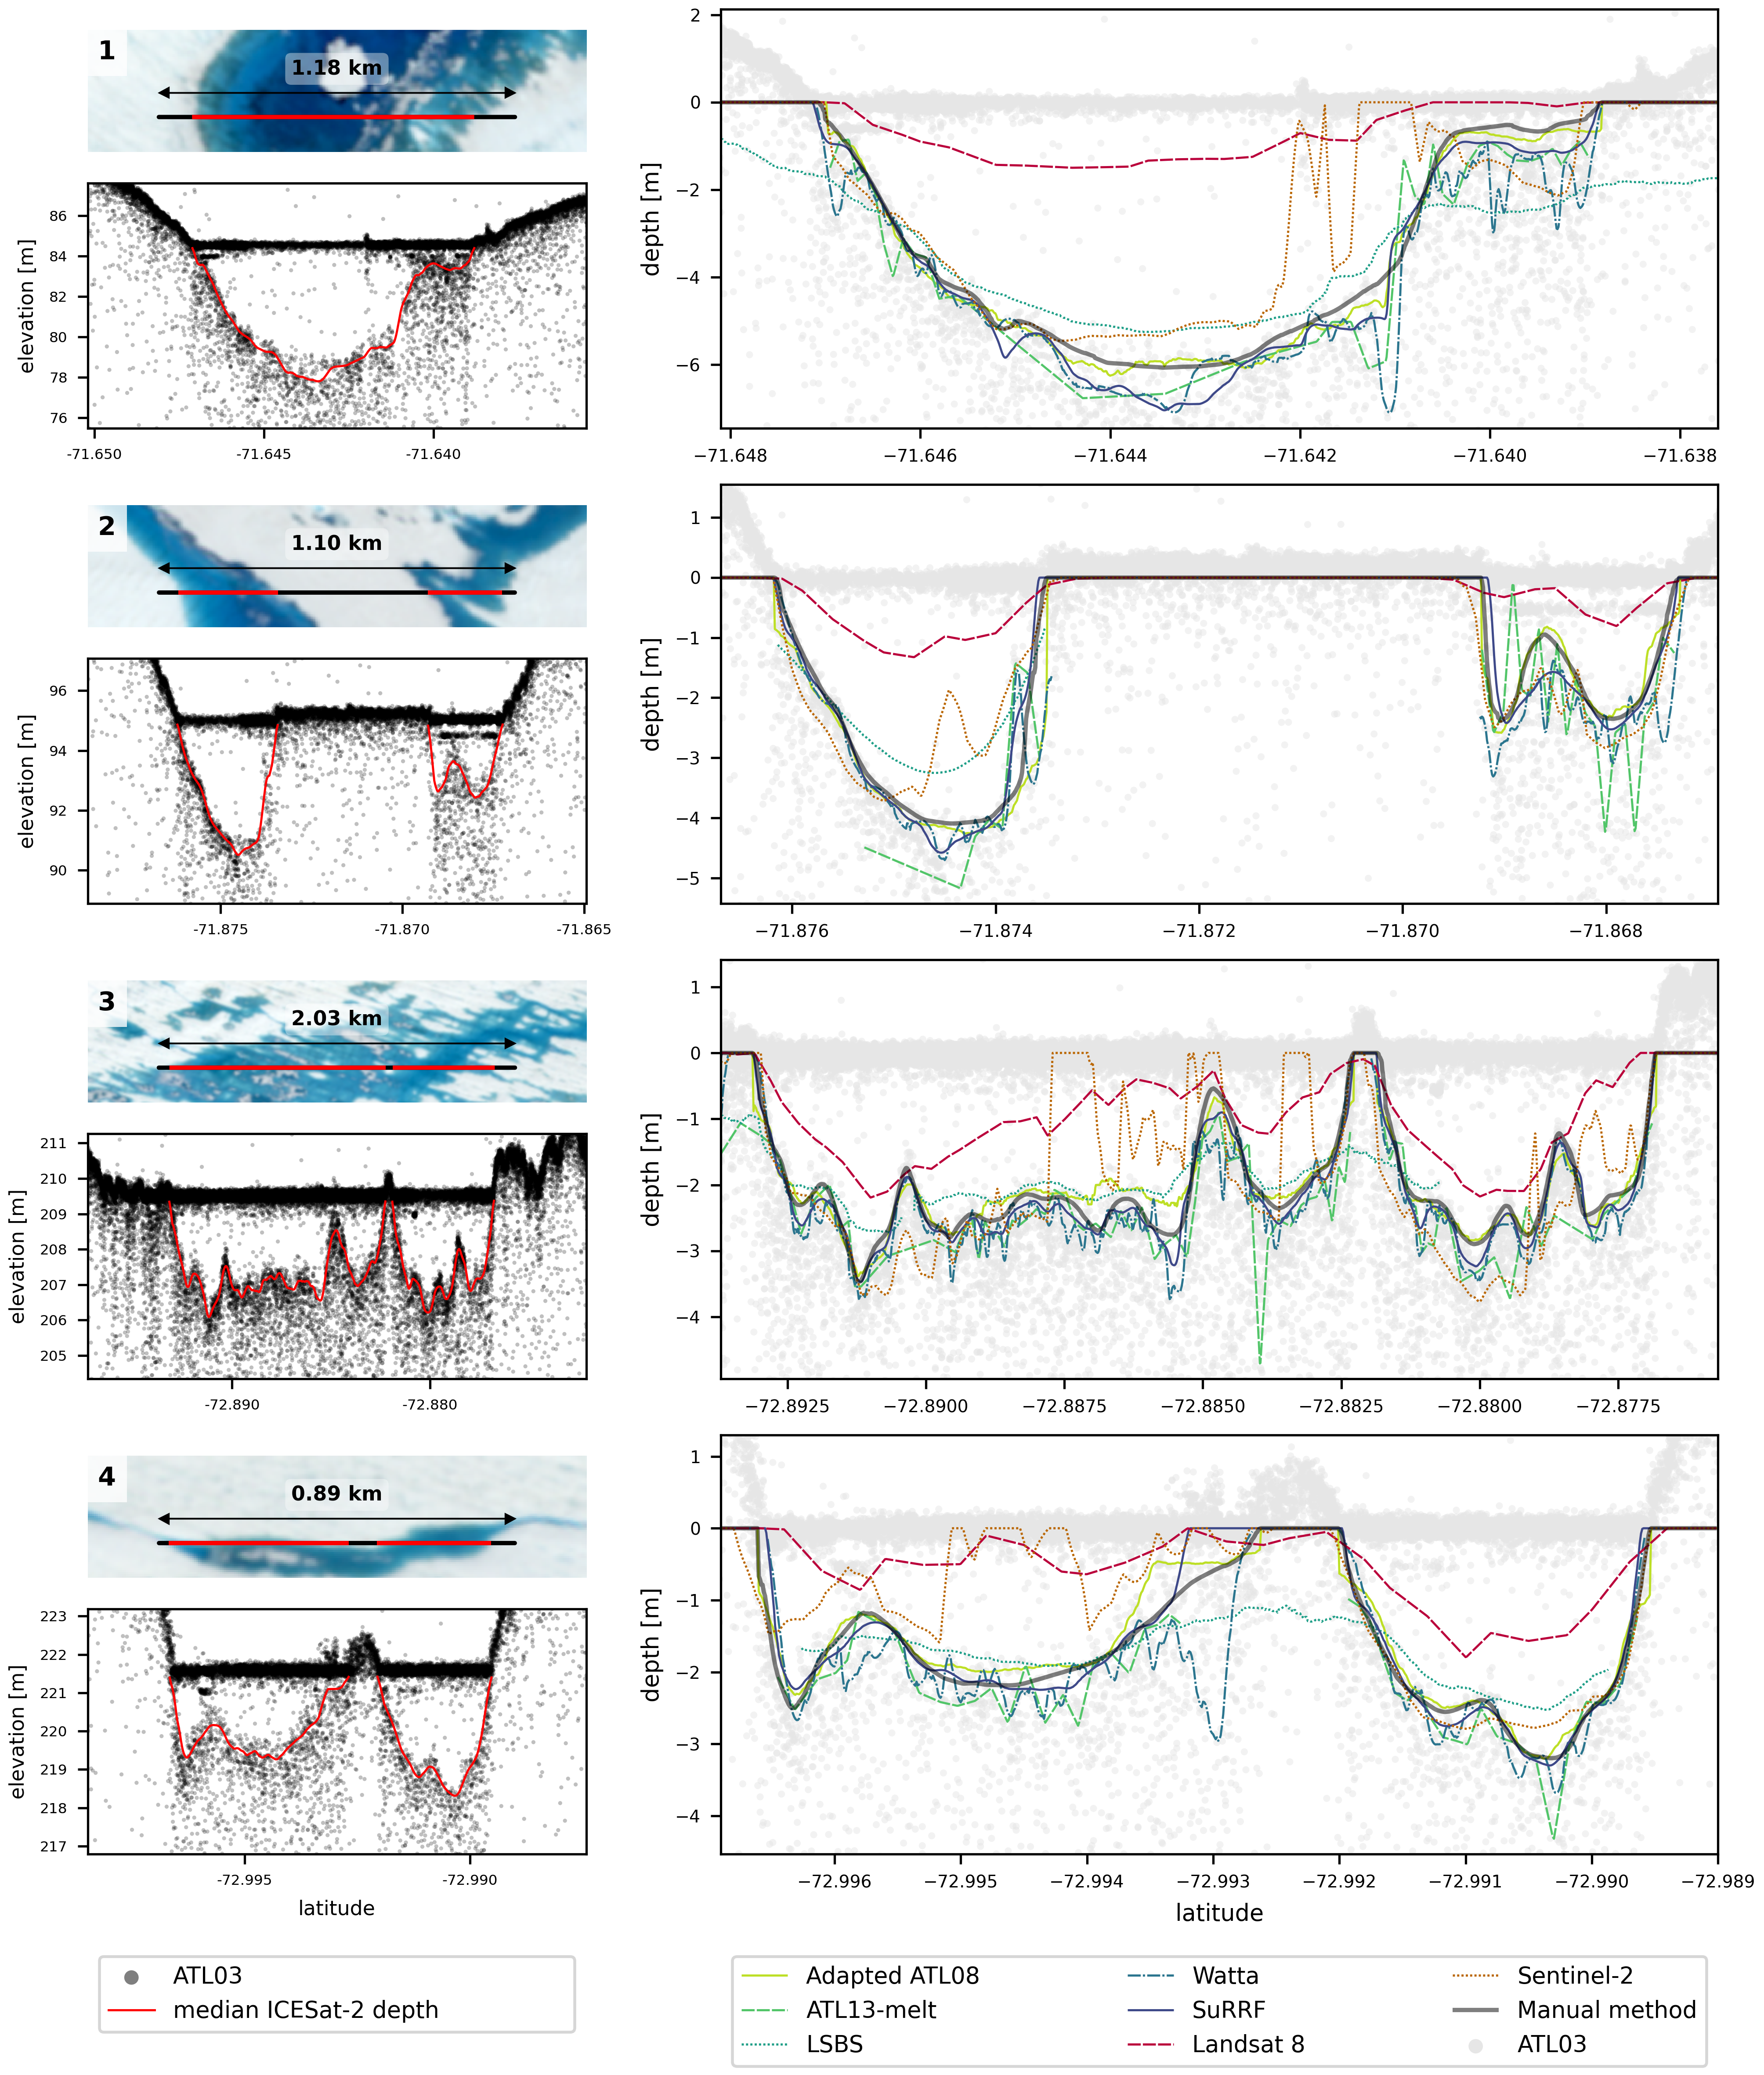

CPU times: user 10.4 s, sys: 3.34 s, total: 13.7 s
Wall time: 11.8 s


In [3]:
%%time

hi_res_output = True

# lines to plot for algorithm figure (without Herzfeld)
names = ['magruder','jasinski','fair_flanner','datta','arndt',
         'spergel_kingslake','moussavi_pope','manual']
algo_labels = ['Adapted ATL08', 'ATL13-melt', 'LSBS', 'Watta', 'SuRRF',
               'Landsat 8','Sentinel-2','Manual method']
cmap = matplotlib.cm.get_cmap('viridis')
is2_cols = cmap(np.linspace(0.9,0.22,5))
other_cols = np.array([[0.72941176, 0., 0.23137255, 1.],
                       [0.72941176, 0.4, 0., 1.],
                       [0,0,0,1]])
algo_cols = np.vstack((is2_cols,other_cols))

algo_ls = [(0, ()), # solid
           (0, (6, 1)), # dashed
           (0, (1, 1)), # dotted
           (0, (6, 1, 1, 1)), # dash-dot
           (0, ()), # solid
           (0, (6, 1)), # dashed
           (0, (1, 1)), # dotted
           (0, ())] # solid


algo_lw = [.5,.5,.5,.5,.5,.5,.5,.5,.5]
algo_lw = np.ones(len(names)) * 0.75
algo_lw[-1] = 1.5
algo_alphas = np.ones(len(names))
algo_alphas[-1] = 0.5

# colors and descriptions for photon confidences
confs = ['noise','buffer','low','medium','high']
confcols = np.array([[0,0,0],
            [121, 157, 189],
            [200, 200, 0],
            [255,165,0],
            [200, 0, 0]]) / 255
cmap = matplotlib.cm.get_cmap('bone')
confcols = cmap(np.linspace(0.95,0.2,5))

# relative horizontal and vertial buffers around the ground track (in which to show satellite imagery)
buffh = 0.2
buffv = 0.07

# make figure with grid-spec
if hi_res_output:
    fig = plt.figure(figsize=[8.5, 10], constrained_layout=True, dpi=300)
else:
    fig = plt.figure(figsize=[8.5, 10], constrained_layout=True)

gs = fig.add_gridspec(13, 3)
plot_imgs = [gs[0,0],gs[3,0],gs[6,0],gs[9,0]]
plot_data = [gs[1:3,0],gs[4:6,0],gs[7:9,0],gs[10:12,0]]
plot_algo = [gs[:3,1:3],gs[3:6,1:3],gs[6:9,1:3],gs[9:12,1:3]]
plot_legend_left = gs[12,0]
plot_legend_right = gs[12,1:3]

gs = fig.add_gridspec(21, 3)
plot_imgs = [gs[0:2,0],gs[5:7,0],gs[10:12,0],gs[15:17,0]]
plot_data = [gs[2:5,0],gs[7:10,0],gs[12:15,0],gs[17:20,0]]
plot_algo = [gs[:5,1:3],gs[5:10,1:3],gs[10:15,1:3],gs[15:20,1:3]]
plot_legend_left = gs[20,0]
plot_legend_right = gs[20,1:3]

# loop through all four ponds
for i,pond in enumerate(ponds):
    
    ######################################################################################
    # PLOT ALGORITHM RESULTS
    ######################################################################################
    
    # reverse the pond numbering order to match it with the other plot
    oldi = 3 - i
    pond = ponds[oldi]
    ax = fig.add_subplot(plot_algo[i])
    
    # plot ATL03 in the background
    p = is2data[pond]
    surf_h = p['picking']['median_surf_height']
    ax.scatter(p['atl03_lat'], p['atl03_h']-surf_h, s=6, c=[[0.9,0.9,0.9]], alpha=0.5, edgecolors='none')
    ax.scatter(0, 0, s=25, c=[[0.9,0.9,0.9]], alpha=1, edgecolors='none',label='ATL03') # for legend
    dfPond = dfdepth[dfdepth.pond.eq(oldi+1)]
    for k,j in enumerate(names):
        ax.plot(-dfPond[j], c=algo_cols[k,:], ls=algo_ls[k], label=algo_labels[k], lw=algo_lw[k], alpha=algo_alphas[k])
    if i == 3:
        ax.set_xlabel('latitude', size=8)
    ax.set_ylabel('depth [m]', size=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xlim(np.array(p['xlims_plot']))
    
    # get the plot limits right
    mx = np.nanmax(-dfPond.iloc[:,:-1])
    mn = np.nanmin(-dfPond.iloc[:,:-1])
    rng = mx-mn
    ax.set_ylim((mn-0.05*rng, mx+0.3*rng))
    if i == 3:
        handles_algo, labels_algo = ax.get_legend_handles_labels()
    
    ######################################################################################
    # PLOT DATA
    ######################################################################################
    ax = fig.add_subplot(plot_data[i])
    
    #plot all ATL03 in black
    ax.scatter(p['atl03_lat'], p['atl03_h'], s=2, c='k', alpha=0.25, edgecolors='none')
    ax.scatter(0, 0, s=25, c='k', alpha=0.5, edgecolors='none',label='ATL03') # for legend
    plot_d = np.full_like(dfPond.manual,fill_value=np.nan)
    for v in np.arange(1,len(dfPond.manual)-1): # to catch edges, just for visualization
        plot_d[v] = 0.01 * dfPond.manual.iloc[v-1] + 0.98 * dfPond.manual.iloc[v] + 0.01 * dfPond.manual.iloc[v+1]
    plot_d[plot_d==0] = np.nan
    plot_d = - plot_d + surf_h
    plot_is2 = -np.abs(np.array(dfPond.med_algorithms))
    plot_is2[plot_is2>-0.15] = np.nan
    plot_is2 += surf_h
    ax.plot(dfPond.index,plot_is2,label='median ICESat-2 depth',lw=0.75,c='r',ls='-')
    
    # labels and limits
    if i == 3:
        ax.set_xlabel('latitude', size=7)
    ax.set_ylabel('elevation [m]', size=7)
    ax.tick_params(axis='both', which='major', labelsize=5)
    xl = - buffh * (p['xlims_plot'][1]-p['xlims_plot'][0]) + p['xlims_plot'][0] 
    xu = buffh * (p['xlims_plot'][1]-p['xlims_plot'][0]) + p['xlims_plot'][1]
    if pond == 'pond2':
        xt = np.arange(np.round(xl-0.01,2),np.round(xu+0.01,2),step=0.01)
    else:
        xt = np.arange(np.round(xl-0.01,2),np.round(xu+0.01,2),step=0.005)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    ax.set_xticks(xt)
    ax.set_xlim((xl,xu))
    mx = np.nanmax(plot_d)
    mn = np.nanmin(plot_d)
    rng = mx-mn
    ax.set_ylim(mn-0.5*rng, mx+0.5*rng)
    #set_xticklabels
    
    # get legend handles and labels 
    if i == 3:
        handles_data, labels_data = ax.get_legend_handles_labels()
    
    ######################################################################################
    # PLOT IMAGERY
    ######################################################################################
    ax = fig.add_subplot(plot_imgs[i])
    imgfn = 'data/sentinel2/ponds/%s_alt.tiff' % pond
    outfn = 'data/sentinel2/ponds/%s_rotated.tiff' % pond
    
    # get the ground track data
    lats = is2data[pond]['xlims_plot']
    df = pd.DataFrame(list(zip(is2data[pond]['atl06_lat'],is2data[pond]['atl06_lon'])),columns=['lat','lon'])
    df.sort_values(by='lat',inplace=True)
    lons = np.interp(lats,df.lat,df.lon, left=np.nan, right=np.nan)
    df = pd.DataFrame(list(zip(is2data[pond]['atl03_lat'],is2data[pond]['atl03_xatc'])),columns=['lat','x_atc'])
    df.sort_values(by='lat',inplace=True)
    x_atcs = np.interp(lats,df.lat,df.x_atc, left=np.nan, right=np.nan)
    
    # open image and transform ground track lat/lon to image CRS
    src = rio.open(imgfn)
    coords_transf = warp.transform({'init': 'epsg:4326'}, src.crs, lons, lats)
    
    # get the angle of the ground track w.r.t. the image CRS
    rot_angle = np.degrees(np.arctan((coords_transf[1][1]-coords_transf[1][0])/(coords_transf[0][1]-coords_transf[0][0])))
    
    # add rotation to the transform
    src_transform = src.transform
    adj_transform = A.rotation(-rot_angle)*A.translation(-src.width*0.9, +src.height/8.0)
    
    upscale_factor = 2
    data = src.read(out_shape=(
            src.count,
            int(src.height * upscale_factor),
            int(src.width * upscale_factor)
        ),
        resampling=Resampling.bilinear)

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    kwargs = src.meta
    src_transform = transform
    adj_transform = A.rotation(-rot_angle)*A.translation(-src.width*0.9*upscale_factor, +src.height*0.125*upscale_factor)
    dst_transform = transform * adj_transform
    kwargs['transform'] = dst_transform
    kwargs['width'] = data.shape[2]
    kwargs['height'] = data.shape[1]
    
    # reproject the image based on the rotated transform
    with rio.open(outfn, 'w', **kwargs) as dst:
        for j, band in enumerate(data, 1):
            dest = np.zeros_like(band)
            reproject(
                band,
                dest,
                src_transform=src_transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=src.crs,
                resampling=Resampling.bilinear)
            dst.write(dest, indexes=j)
    
    # open reprojected image and show in axes
    thisImg = rio.open(outfn)
    rgb = np.zeros((thisImg.height,thisImg.width,thisImg.count))
    for j in range(thisImg.count):
        rgb[:,:,j] = np.power(thisImg.read(j+1)/255,0.7)
    ax.imshow(np.flipud(rgb))
    
    # transform ground track to image CRS, then to pixel coordinates of rotated image, show on plot
    coords_transf = warp.transform({'init': 'epsg:4326'}, thisImg.crs, lons, lats)
    px = TransformMethodsMixin.index(thisImg,coords_transf[0],coords_transf[1],precision=5)
    px = (list(-np.array(px[0]) + thisImg.height - 1),px[1])
    
    dflonlat = pd.DataFrame(list(zip(is2data[pond]['atl06_lat'],is2data[pond]['atl06_lon'])),columns=['lat','lon'])
    dflonlat.sort_values(by='lat',inplace=True)
    gt_coords = warp.transform({'init': 'epsg:4326'}, thisImg.crs, dflonlat.lon, dflonlat.lat)
    px_gt = TransformMethodsMixin.index(thisImg,gt_coords[0],gt_coords[1],precision=5)
    px_gt = (list(-np.array(px_gt[0]) + thisImg.height - 1),px_gt[1])
    
    pondlats = np.array(dfPond.index)
    pondlons = np.interp(pondlats,dflonlat.lat,dflonlat.lon, left=np.nan, right=np.nan)
    gt_plot = warp.transform({'init': 'epsg:4326'}, thisImg.crs, pondlons, pondlats)
    px_pond = TransformMethodsMixin.index(thisImg,gt_plot[0],gt_plot[1],precision=5)
    px_pond = (list(-np.array(px_pond[0]) + thisImg.height - 1),px_pond[1])
    pxx = np.array(px_pond[1]).astype(float)
    pxy = np.array(px_pond[0]).astype(float)
    ax.plot(pxx,pxy,'k-',lw=1.5,solid_capstyle="round")
    pxx[np.isnan(plot_is2)] = np.nan
    pxy[np.isnan(plot_is2)] = np.nan
    ax.plot(pxx,pxy,'r-',lw=1.5,solid_capstyle="butt")
    
    # set proper the x and y limits
    xl = - buffh * (px[1][1]-px[1][0]) + px[1][0] 
    xu = buffh * (px[1][1]-px[1][0]) + px[1][1] 
    ax.set_xlim((xl,xu))
    xwid = xu-xl
    yl = - buffv * xwid + px[0][0]
    yu = buffv * 2.5 * xwid + px[0][0] 
    ax.set_ylim((yl,yu))
    asp = (xu-xl) / (yu-yl)
    ax.axis('off')
    
    # add pond name / title
    props = dict(facecolor='white', alpha=0.8, linewidth=0)
    ax.text(0.02, 1-0.02*asp,'%d' % (i+1),transform = ax.transAxes,verticalalignment='top',horizontalalignment='left',
               fontsize=9, fontweight='bold', bbox=props)
    
    # add length arrow with description
    y_arr = px[0][0]+0.7*buffv*(xu-xl)
    headscale = 0.02
    ax.arrow(px[1][0],y_arr,px[1][1]-px[1][0],0,head_width=headscale*xwid, head_length=headscale*xwid, 
             fc='k', ec='k',lw=0.5,ls='-',length_includes_head=True,snap=True)
    ax.arrow(px[1][1],y_arr,-px[1][1]+px[1][0],0,head_width=headscale*xwid, head_length=headscale*xwid, 
             fc='k', ec='k',lw=0.5,ls='-',length_includes_head=True,snap=True)
    props = dict(boxstyle='round', facecolor='white', alpha=0.4, linewidth=0)
    ax.text(0.5, 0.68, '%.2f km' % (np.abs(x_atcs[0]-x_atcs[1])/1000), transform=ax.transAxes, fontsize=7, verticalalignment='center',
            horizontalalignment='center', fontweight='bold',color='k', bbox=props)

# add legend for data plots
ax = fig.add_subplot(plot_legend_left)
ax.legend(handles_data[1:] + [handles_data[0]], labels_data[1:] + [labels_data[0]],
          loc='upper left',fontsize=8,ncol=1,mode='expand')
ax.axis('off')

# add legend for algorithm plots
ax = fig.add_subplot(plot_legend_right)
ax.legend(handles_algo, labels_algo,loc='upper left',fontsize=8,ncol=3,mode='expand')
ax.axis('off')

# save figure at 300 dpi when requesting high resolution output
if hi_res_output:
    plt.savefig('figs/Fig2_amery_melt_comparison.png')